## Predicting Voter Turnout Probability Score
**Author:** `'Bode Oyeneye.`

#### Preamble
In this project, one is tasked with predicting voter turnout probability scores using logistic regression and gradient-boosted trees. The goal is to estimate the likelihood of voters casting their ballots in an election, which is crucial for campaign teams to effectively allocate their resources. We are specifically interesting in using logistic regression and gradient-boost tree to predict voters turnout probability score.

#### Objective
Objective: The primary objective is to help political campaigns mobilize minimal resources for maximum impact. To achieve this, we need to minimize both false positives and false negatives during prediction, while maximizing the true positive rate (TPR) and true negative rate (TNR). This ensures that resources are efficiently focused on likely voters, and that the campaign avoids wasting resources on individuals who are unlikely to vote or are ineligible.

##### General Assumptions

- **Voter Status**: A voter is considered alive unless flagged as deceased
- **Voter Status**: A voter is considered registered as a permanent absentee or early voter only if explicitly marked as such. Any other possible status is ignored for the purpose of this analysis.
- **Turnout Definition**: Voter turnout is defined within the probability range of 20% to 70%. Turnout is classified as:
  - A (Absentee), E (Early Voting), and Y (Voted) all indicate that the voter has turned out to vote.
  - N (Did Not Vote) and I (Ineligible) indicate that the voter did not participate in the election.

In [1]:
# Import relevant libraries

import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from matplotlib import rcParams
from statistics import mode
from sklearn import metrics
from sklearn.metrics import (roc_curve, precision_recall_curve, confusion_matrix, 
                             ConfusionMatrixDisplay, log_loss, make_scorer)
from sklearn.impute import KNNImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OrdinalEncoder,OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from missforest import MissForest
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

%matplotlib inline
pd.set_option('display.max_columns', 50)

### 1. Load input data

In [2]:
# function to load the input data into panda dataframe

def load_voter_data():
    return pd.read_csv("../datasets/data_challenge_2021_September_24.csv")

In [3]:
voter_df=load_voter_data()
voter_df.tail()

,index,actual_turnout,deceased,discretionary_income,dob,first_time_seen,gender,home_type,household_income,lat,lon,marital_status,mover_status,permanent_absentee,precinct_id,race_ethnicity,reg_party,registration_date,vote_history1,vote_history2,vote_history3,voter_status
199979,106710,A,NaN,43.0,19930727,NaN,Female,NaN,158.0,40.710329,-73.952362,Married,Resides at Current Address,Y,591.0,B,Democrat,2019-06-17,N,A,N,Active
199980,15622,N,NaN,NaN,19910920,20170210.0,Female,NaN,NaN,40.678932,-73.974783,Unmarried,Resides at Current Address,Y,553.0,D,No Party,2010-02-11,N,N,N,Active
199981,156940,A,NaN,NaN,19650130,20170210.0,Female,APT,NaN,40.673750,-73.888893,Unmarried,Resides at Current Address,Y,721.0,B,Democrat,2005-01-20,Y,Y,N,Active
199982,183955,A,NaN,51.0,19630916,20170210.0,Male,NaN,188.0,40.710808,-73.946184,Unmarried,Resides at Current Address,Y,599.0,B,Republican,2016-03-30,N,Y,N,Active
199983,67595,A,NaN,66.0,19450701,20170210.0,Female,NaN,350.0,40.643214,-73.976169,Married,Resides at Current Address,Y,172.0,B,Democrat,1976-09-29,Y,Y,Y,Active


In [4]:
# Comparing both voter_df index and its column index
print(voter_df.shape,voter_df['index'].min(),voter_df['index'].max())

# extracting where idx is not sequential (0 - 199999 as opposed to 0 to 199984)
print([i for i in voter_df.index.values if i not in voter_df['index'].values])

(199984, 22) 0 199999
[373, 46441, 51877, 59856, 67000, 69391, 69779, 71792, 82443, 88757, 92027, 114285, 165006, 184178, 190863, 192219]


In [5]:
# the index column was not described as a feature in the project description (it's just an index)
# resetting index serially in sequential order for simplicity

voter_df=voter_df.drop("index", axis=1)
voter_df.head()

,actual_turnout,deceased,discretionary_income,dob,first_time_seen,gender,home_type,household_income,lat,lon,marital_status,mover_status,permanent_absentee,precinct_id,race_ethnicity,reg_party,registration_date,vote_history1,vote_history2,vote_history3,voter_status
0,A,NaN,54.0,19821216,NaN,Male,NaN,288.0,40.682232,-73.914796,Unmarried,Resides at Current Address,Y,704.0,B,Democrat,2021-06-04,N,Y,N,Active
1,A,NaN,28.0,19780615,NaN,Male,NaN,85.0,40.600094,-73.948403,Unmarried,Resides at Current Address,Y,35.0,B,Democrat,2021-03-24,N,Y,N,Active
2,A,NaN,39.0,19441028,NaN,Female,NaN,145.0,40.674683,-73.971920,Married,Resides at Current Address,Y,557.0,B,Republican,2021-06-12,N,Y,Y,Active
3,A,NaN,37.0,19840617,20200929.0,Female,APT,135.0,40.592504,-73.978713,Unmarried,Resides at Current Address,Y,236.0,B,Democrat,2020-09-22,N,Y,N,Active
4,A,NaN,NaN,19960523,NaN,Male,NaN,NaN,40.617752,-74.022785,Unmarried,Resides at Current Address,Y,298.0,F,Democrat,2020-06-16,N,N,N,Active


### 2. Data wrangling

In [6]:
voter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199984 entries, 0 to 199983
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   actual_turnout        199984 non-null  object 
 1   deceased              121 non-null     object 
 2   discretionary_income  157158 non-null  float64
 3   dob                   199984 non-null  int64  
 4   first_time_seen       107536 non-null  float64
 5   gender                199984 non-null  object 
 6   home_type             22893 non-null   object 
 7   household_income      157158 non-null  float64
 8   lat                   199984 non-null  float64
 9   lon                   199984 non-null  float64
 10  marital_status        199984 non-null  object 
 11  mover_status          199984 non-null  object 
 12  permanent_absentee    158329 non-null  object 
 13  precinct_id           199984 non-null  float64
 14  race_ethnicity        199984 non-null  object 
 15  

In [7]:
# extracting cols containing missing values

nan_cols = [col for col in voter_df.columns if voter_df[col].isnull().values.any()]
print(nan_cols)

['deceased', 'discretionary_income', 'first_time_seen', 'home_type', 'household_income', 'permanent_absentee']


In [8]:
# Determing the percent of missing values in each of the missing value containing columns

lambda_nan_percent = lambda x:round((len(x)-x.count())/len(x)*100,2)
lambda_nan_percent.__name__ = "missing_percent"
voter_df[nan_cols].agg(['count',lambda_nan_percent])

,deceased,discretionary_income,first_time_seen,home_type,household_income,permanent_absentee
count,121.00,157158.00,107536.00,22893.00,157158.00,158329.00
missing_percent,99.94,21.41,46.23,88.55,21.41,20.83


#### 2.1 Handling missing values and imputation

The deceased, discretionary_income,first_time_seen, home_type, household_income and permanent_absentee columns contain null values. In the case of deceased column, I will $\textbf assume$ that if a voter is not flagged as deceased then he/she is alive. Likewise, when permanent_absentee is not flagged, then the voter is neither a permanent absentee nor early voter. Under normal circumstances, I would rather check with the domain experts as opposed to making such assumptions.

<i/>Assumption 1: If not flagged as deceased, then the voter is alive </br>
<i/>Assumption 2: If not flagged as permanent absentee/early voter, then the voter is not registered with the state as a permanent absentee/early voter

In [9]:
# Applying assumptions one and two to columns deceased and permanent_absentee respectively

voter_df.fillna({"deceased":"Alive"}, inplace=True)
voter_df.fillna({"permanent_absentee":"N"}, inplace=True)

As previously determined the column "home_type" has over 88% missing values, thus I will be dropping it for now because it contains way too much missing values

In [10]:
# dropping the home_type column 

voter_df.drop("home_type", axis=1, inplace=True)

#### 2.2 Feature engineering

In [11]:
# Generating age and reg_age columns (in year) for the dob and registration_date columns
# months or days can be extracted as well, but for ticking to year for simplicity. Subsequent works might require such.

voter_df['dob'] = pd.to_datetime(voter_df['dob'].astype(str),format='%Y%m%d')
voter_df['age'] = voter_df['dob'].apply(lambda x: date.today().year - x.year - (
                        (x.month, x.day)>(date.today().month,date.today().day)))

voter_df['registration_date'] = pd.to_datetime(voter_df['registration_date'].astype(str),format='%Y-%m-%d')
voter_df['reg_age'] = voter_df['registration_date'].apply(lambda x: date.today().year - x.year - (
                        (x.month, x.day)>(date.today().month,date.today().day)))

# converting column first_time_seen to datetime format
voter_df['first_time_seen'] = pd.to_datetime(voter_df['first_time_seen'],errors='coerce',format='%Y%m%d')
voter_df.head()

,actual_turnout,deceased,discretionary_income,dob,first_time_seen,gender,household_income,lat,lon,marital_status,mover_status,permanent_absentee,precinct_id,race_ethnicity,reg_party,registration_date,vote_history1,vote_history2,vote_history3,voter_status,age,reg_age
0,A,Alive,54.0,1982-12-16,NaT,Male,288.0,40.682232,-73.914796,Unmarried,Resides at Current Address,Y,704.0,B,Democrat,2021-06-04,N,Y,N,Active,42,3
1,A,Alive,28.0,1978-06-15,NaT,Male,85.0,40.600094,-73.948403,Unmarried,Resides at Current Address,Y,35.0,B,Democrat,2021-03-24,N,Y,N,Active,46,3
2,A,Alive,39.0,1944-10-28,NaT,Female,145.0,40.674683,-73.971920,Married,Resides at Current Address,Y,557.0,B,Republican,2021-06-12,N,Y,Y,Active,80,3
3,A,Alive,37.0,1984-06-17,2020-09-29,Female,135.0,40.592504,-73.978713,Unmarried,Resides at Current Address,Y,236.0,B,Democrat,2020-09-22,N,Y,N,Active,40,4
4,A,Alive,NaN,1996-05-23,NaT,Male,NaN,40.617752,-74.022785,Unmarried,Resides at Current Address,Y,298.0,F,Democrat,2020-06-16,N,N,N,Active,28,4


In [12]:
voter_df.describe(include="object")

,actual_turnout,deceased,gender,marital_status,mover_status,permanent_absentee,race_ethnicity,reg_party,vote_history1,vote_history2,vote_history3,voter_status
count,199984,199984,199984,199984,199984,199984,199984,199984,199984,199984,199984,199984
unique,5,2,3,3,6,2,6,8,5,5,5,1
top,A,Alive,Female,Unmarried,Resides at Current Address,Y,B,Democrat,N,Y,N,Active
freq,155682,199863,88378,126669,190882,158329,126846,106228,162328,119841,138113,199984


In [13]:
len(voter_df['dob'].unique()), len(voter_df['registration_date'].unique()), 

(27507, 10589)

Voted by absentee ballot (A), early voting (E), and voter casts a ballot (Y) were considered as turnout </br>
Unregistered or didn't vote (N) and the voter was ineligible at the time of the election (I) implies the voter does not turnout to vote

In [14]:
ab = voter_df.copy()

In [15]:
# Testing the proposal that those who almost always vote generally do not need the push, and
# That those who never vote are unlikely to do so even with additional outreach.

ab['vote_history'] = np.where(((ab.vote_history1.isin(["A","E","Y"])) &
                               (ab.vote_history2.isin(["A","E","Y"])) &
                               (ab.vote_history3.isin(["A","E","Y"]))) |
                              ((ab.vote_history1.isin(["I","N"])) & 
                               (ab.vote_history2.isin(["I","N"])) &
                               (ab.vote_history3.isin(["I","N"]))),
                              'always','need_push')

conditions_1 = [((ab.vote_history=='always') &
               (ab.vote_history1.isin(["A","E","Y"])) & 
               (ab.vote_history2.isin(["A","E","Y"])) &
               (ab.vote_history3.isin(["A","E","Y"]))),
              ((ab.vote_history=='always') &
               (ab.vote_history1.isin(["I","N"])) & 
               (ab.vote_history2.isin(["I","N"])) &
               (ab.vote_history3.isin(["I","N"]))),
              (ab.vote_history=='need_push')]

values = ['always_vote', 'always_no_vote', 'need_push']                                  
ab['vote_history'] = np.select(conditions_1, values)

ab['turnout_code'] = np.where(ab.actual_turnout.isin(["A","E","Y"]),"yes","no")

In [16]:
len(ab.loc[(ab.vote_history=="always_vote") & (ab.turnout_code=="no")])

645

In [17]:
len(ab.loc[(ab.vote_history=="always_no_vote") & (ab.turnout_code=="yes")])

41672

In [19]:
need_push_index = ab.index[ab.vote_history=='need_push'].tolist()
ab.loc[need_push_index].head()

,actual_turnout,deceased,discretionary_income,dob,first_time_seen,gender,household_income,lat,lon,marital_status,mover_status,permanent_absentee,precinct_id,race_ethnicity,reg_party,registration_date,vote_history1,vote_history2,vote_history3,voter_status,age,reg_age,vote_history,turnout_code
0,A,Alive,54.0,1982-12-16,NaT,Male,288.0,40.682232,-73.914796,Unmarried,Resides at Current Address,Y,704.0,B,Democrat,2021-06-04,N,Y,N,Active,39,0,need_push,yes
1,A,Alive,28.0,1978-06-15,NaT,Male,85.0,40.600094,-73.948403,Unmarried,Resides at Current Address,Y,35.0,B,Democrat,2021-03-24,N,Y,N,Active,43,0,need_push,yes
2,A,Alive,39.0,1944-10-28,NaT,Female,145.0,40.674683,-73.971920,Married,Resides at Current Address,Y,557.0,B,Republican,2021-06-12,N,Y,Y,Active,77,0,need_push,yes
3,A,Alive,37.0,1984-06-17,2020-09-29,Female,135.0,40.592504,-73.978713,Unmarried,Resides at Current Address,Y,236.0,B,Democrat,2020-09-22,N,Y,N,Active,37,1,need_push,yes
5,A,Alive,NaN,1967-10-10,2019-08-16,Female,NaN,40.648142,-74.009585,Unmarried,Resides at Current Address,Y,486.0,F,Other,2019-07-11,N,Y,Y,Active,54,2,need_push,yes


Herewith, attempts made at testing the proposal that voters history who showed consistent non turnout attitudes, could potentially vote at the nearest future, and those with consistent voting history (i.e. voted during the three historic voting periods) have the potential of not turning out at the futuric voting events (absentee and early voting inclusives). </br>

However consistent with partners' objective, while other imputations were conducted with all the datasets. My training models will be limited to voters without only spotty voting history, that is those with a perfect voting or non-voting history are excluded

#### 2.3 Other imputation

Different imputation techniques were explored for the numerical columns: discretionary_income and household_income to ascertain the best choice of imputation based on the feature distribution.Specifically, mean, median, mode and scaled-knn and missforest inputations were explored

In [20]:
def create_imputed_cols(df,cols=["discretionary_income","household_income"]):
    new_df = df[cols].copy()
    num_cols = ["discretionary_income","household_income","lat","lon","age","reg_age"]
    for col in cols:
        # create mean, median and mode cols
        new_df[f'{col}_mean'] = new_df[col].fillna(new_df[col].mean())
        new_df[f'{col}_median'] = new_df[col].fillna(new_df[col].median())
        new_df[f'{col}_mode'] = new_df[col].fillna(mode(new_df[col]))
        
    # scaling for knn_imputer
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df[num_cols].copy())
    scaled_df = pd.DataFrame(scaled_df,columns=num_cols)
        
    # knn imputation
    knn_imputed = KNNImputer(n_neighbors=3)
    knn_imputed = knn_imputed.fit_transform(scaled_df)
    knn_imputed = pd.DataFrame(knn_imputed,columns=num_cols)
    
    # inverse scaling
    knn_imputed = scaler.inverse_transform(knn_imputed)
    knn_imputed = pd.DataFrame(knn_imputed,columns=num_cols)

    missforest_impute = MissForest()
    missforest_impute = missforest_impute.fit_transform(df[num_cols].copy())
    missforest_impute = pd.DataFrame(missforest_impute,columns=num_cols)
    
    for col in cols:
        new_df[f'{col}_missforest'] = missforest_impute[col].copy()
        new_df[f'{col}_knn_scaled'] = knn_imputed[col].copy()
    
    new_df = new_df[sorted(new_df.columns)]
    return new_df, new_df.describe().loc[['mean', 'std', 'min', '50%', 'max']]

In [21]:
def visualize_num_imputations(df,cols=["discretionary_income","household_income"]):
    
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)
    for i in range(len(cols)):
        new_cols=[cols[i]] + [f'{cols[i]}_{x}' for x in ["knn_scaled","mean","median","mode","missforest"]]
        sns.kdeplot(data=df[new_cols],ax=axs[i],legend=True).set(title=f'{cols[i]} Imputation Results')
    plt.tight_layout()
    plt.show()

In [22]:
%%time
imputed_df,imputed_df_summary = create_imputed_cols(voter_df)
imputed_df_summary.T

Iteration: 0
Iteration: 1
Wall time: 15min 51s


,mean,std,min,50%,max
discretionary_income,38.877518,40.747454,0.0,31.000000,2336.0
discretionary_income_knn_scaled,38.230958,38.028084,0.0,31.000000,2336.0
discretionary_income_mean,38.877518,36.121918,0.0,38.877518,2336.0
discretionary_income_median,37.190570,36.266185,0.0,31.000000,2336.0
discretionary_income_missforest,40.274832,36.266815,0.0,39.000000,2336.0
discretionary_income_mode,37.190570,36.266185,0.0,31.000000,2336.0
household_income,152.029454,198.182128,1.0,111.000000,4785.0
household_income_knn_scaled,149.256526,185.670752,1.0,108.000000,4785.0
household_income_mean,152.029454,175.685052,1.0,135.000000,4785.0
household_income_median,143.243114,176.489484,1.0,111.000000,4785.0


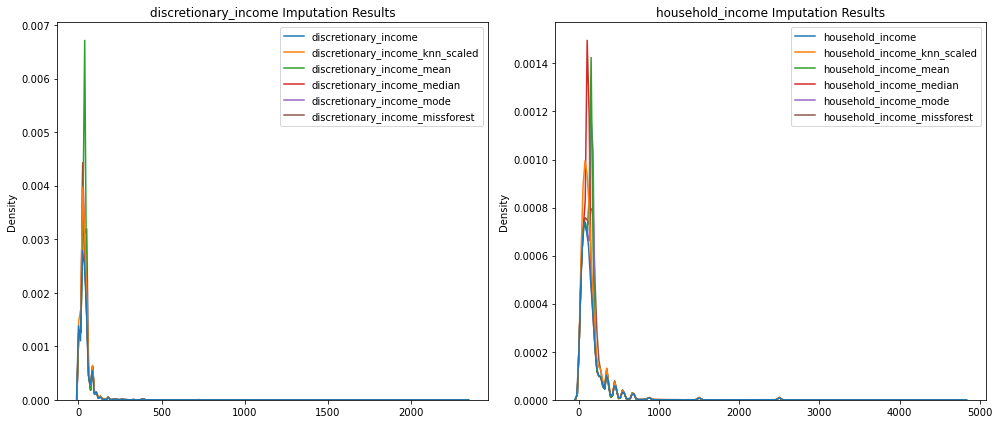

In [23]:
visualize_num_imputations(imputed_df)

Close inspection of the plot and table above showed that knn_scaled imputation offers better results for the discretionary_income and household_income features with respected to their corresponding distribution (its center and spread). Thus two features in the voter_df will be subsequenetly imputed with the scaled knn technique.

In [24]:
voter_df['discretionary_income']=imputed_df['discretionary_income_knn_scaled'].copy()
voter_df['household_income']=imputed_df['household_income_knn_scaled'].copy()

In [25]:
voter_df.describe()

,discretionary_income,household_income,lat,lon,precinct_id,age,reg_age
count,199984.000000,199984.000000,199984.000000,199984.000000,199984.000000,199984.000000,199984.000000
mean,38.230958,149.256526,40.653262,-73.963652,375.352473,50.207247,6.117729
std,38.028084,185.670752,0.038868,0.030894,240.504093,18.650998,9.401701
min,0.000000,1.000000,40.572004,-74.040649,0.000000,18.000000,0.000000
25%,22.000000,65.000000,40.623082,-73.986225,166.000000,35.000000,1.000000
50%,31.000000,108.000000,40.655051,-73.960153,358.000000,50.000000,2.000000
75%,44.000000,163.000000,40.683897,-73.945067,559.000000,64.000000,5.000000
max,2336.000000,4785.000000,40.737969,-73.860155,1086.000000,122.000000,81.000000


### 3. Exploratory data analysis

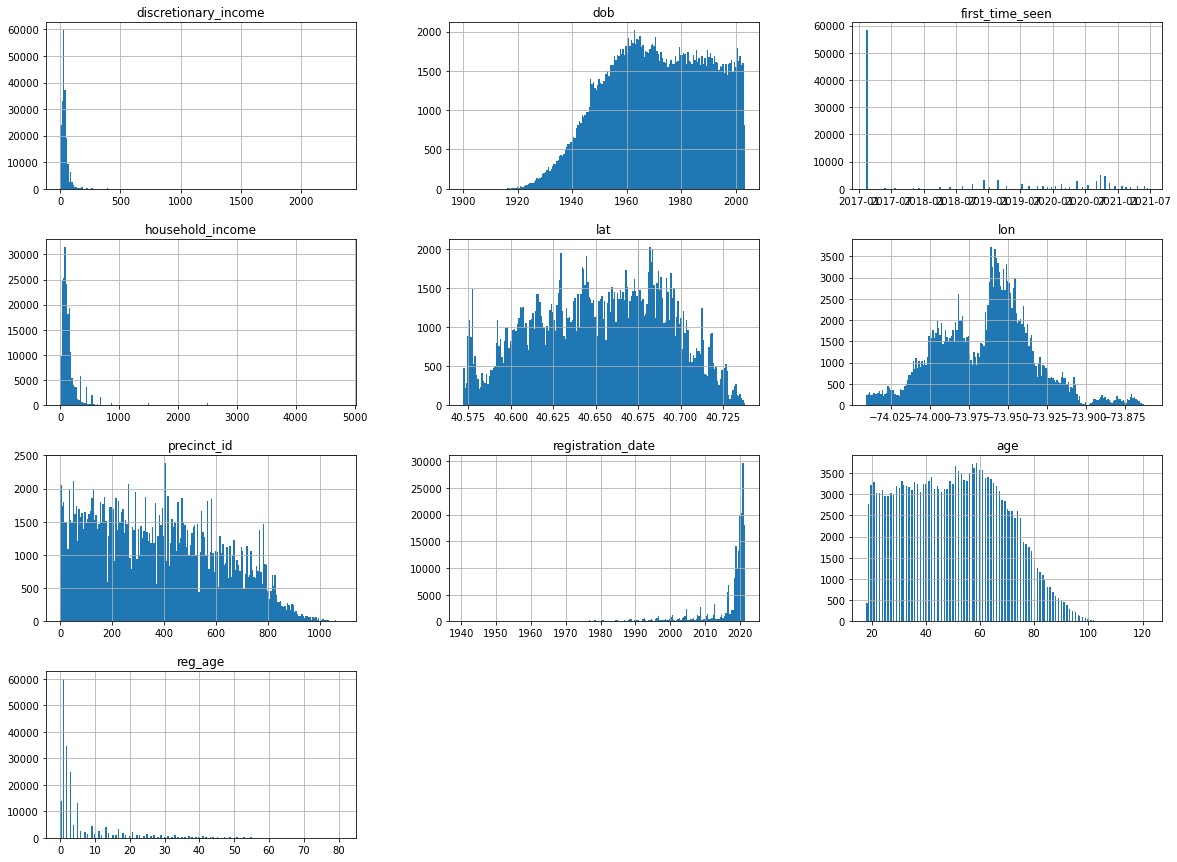

In [26]:
voter_df.hist(bins=200,figsize=(20,15))
plt.show()

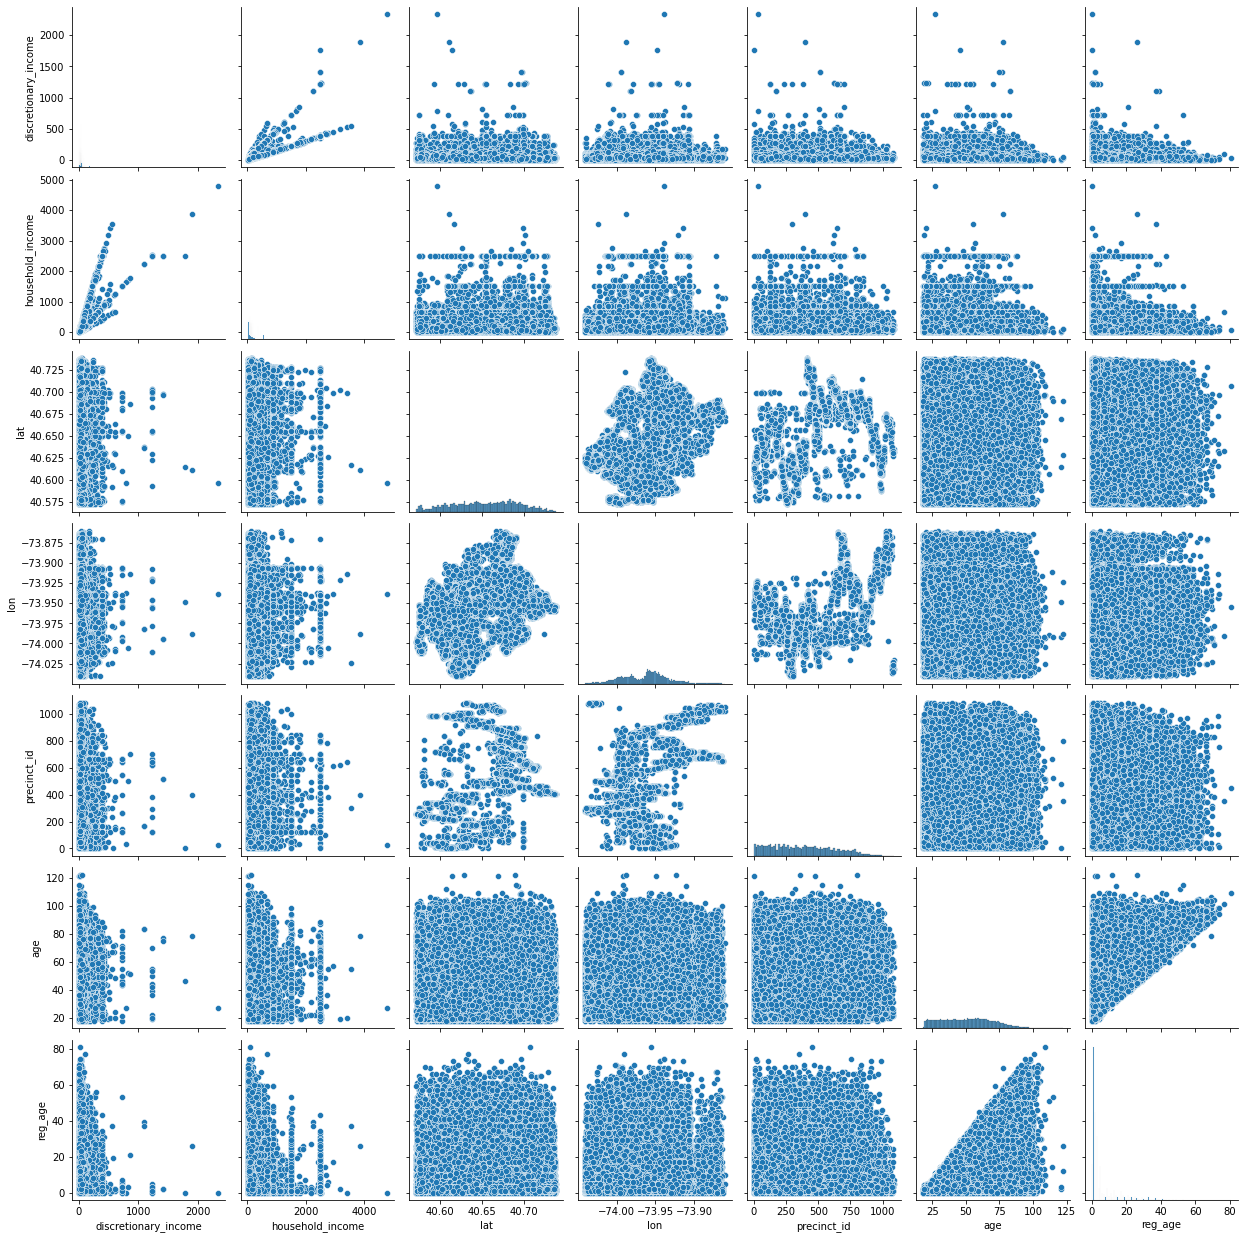

In [27]:
sns.pairplot(voter_df)
plt.show()

In [28]:
# conducting pearson correlation on the dataset
voter_df.corr()

,discretionary_income,household_income,lat,lon,precinct_id,age,reg_age
discretionary_income,1.000000,0.841312,-0.011539,0.020932,0.013375,-0.051584,-0.016170
household_income,0.841312,1.000000,-0.005089,0.025437,0.018088,-0.062819,-0.035264
lat,-0.011539,-0.005089,1.000000,0.340325,0.557905,-0.006667,-0.006202
lon,0.020932,0.025437,0.340325,1.000000,0.189942,-0.012365,-0.000078
precinct_id,0.013375,0.018088,0.557905,0.189942,1.000000,-0.002156,0.000297
age,-0.051584,-0.062819,-0.006667,-0.012365,-0.002156,1.000000,0.389718
reg_age,-0.016170,-0.035264,-0.006202,-0.000078,0.000297,0.389718,1.000000


In [29]:
# writing a function for visualizing correlation data

def corr_heatmap(corr_df, figsize=(10,10), annot=False, cbar=True):
    """Return a heatmap of a dataframe containing 
    Pearson correlation values
    
    Arg
    ---
        corr_df: a Pandas.DataFrame correlation table
    """
    # define figure
    fig, ax = plt.subplots(figsize=figsize)
    
    corr_df = np.round(corr_df,decimals=3)
    
    sns.heatmap(corr_df, annot=annot, fmt='.2g',
                annot_kws={'size': 14}, square=True, 
                cbar=cbar, cmap="YlGnBu", cbar_kws={"shrink": .75})
    plt.title('Pearson Correlations for the voter data', fontsize=20)
    plt.xlabel('Features', fontsize=18)
    plt.xticks(fontsize=12, rotation='vertical')
    plt.ylabel('Features', fontsize=18)
    plt.yticks(fontsize=12, rotation='horizontal')
    plt.tight_layout()
    
    plt.show()

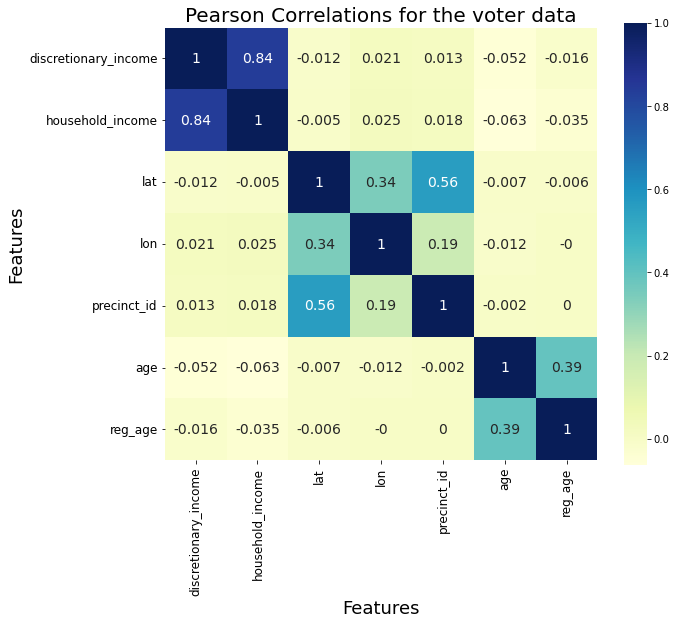

In [30]:
# visualizing the Pearson correlation with seaborn heatmap
corr_heatmap(voter_df.corr(),annot=True)

There exist a very strong positive correlation between discretionary_income and household_income (~0.84). One approach here is to use PCA method to combine the two features to minimize the effect of multicollinearity for Logistic regression. However this is not necessary for XGB Classifier.

### 4. Splitting and training data wrangling

In [31]:
# remove voter_status from voter_df, it adds no variability to the labels
# remove first_time_seen and extract years from registration_date
# eliminating those with consistent history (always voting or never voting)

all_cols = ['actual_turnout', 'deceased', 'discretionary_income', 'gender', 'household_income', 'lat', 'lon','marital_status',
'mover_status', 'permanent_absentee', 'precinct_id', 'race_ethnicity', 'reg_party', 'reg_age', 'vote_history1',
'vote_history2', 'vote_history3', 'age']
new_voter_df = voter_df.loc[need_push_index, all_cols]
new_voter_df['turnout_code'] = np.where(new_voter_df['actual_turnout'].isin(["A","E","Y"]),"yes","no")
new_voter_df.drop('actual_turnout', axis=1, inplace=True)
train_set, test_set = train_test_split(new_voter_df, test_size=0.2, random_state=42)

In [32]:
new_voter_df.loc[new_voter_df['turnout_code']=='no']

,deceased,discretionary_income,gender,household_income,lat,lon,marital_status,mover_status,permanent_absentee,precinct_id,race_ethnicity,reg_party,reg_age,vote_history1,vote_history2,vote_history3,age,turnout_code
25,Alive,9.000000,Male,35.000000,40.638806,-73.947179,Married,Resides at Current Address,Y,76.0,D,Democrat,1,N,Y,N,34,no
45,Alive,17.000000,Male,53.000000,40.624779,-73.956432,Unmarried,Resides at Current Address,Y,374.0,A,Democrat,0,A,A,N,57,no
75,Alive,31.000000,Female,95.000000,40.704914,-73.955329,Unmarried,Resides at Current Address,Y,455.0,B,Democrat,1,N,Y,N,66,no
81,Alive,28.000000,Male,86.000000,40.673468,-73.972747,Unmarried,Resides at Current Address,Y,556.0,B,Other,0,N,Y,N,25,no
126,Alive,37.000000,Unknown,135.000000,40.616187,-73.987209,Unmarried,Resides at Current Address,N,406.0,C,No Party,2,Y,N,Y,45,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199872,Alive,16.666667,Male,47.333333,40.645121,-74.012126,Unmarried,Resides at Current Address,Y,482.0,C,Democrat,1,N,Y,N,56,no
199876,Alive,31.000000,Male,108.000000,40.621211,-73.958518,Unmarried,Resides at Current Address,N,368.0,D,Democrat,2,N,Y,N,53,no
199904,Alive,9.000000,Female,35.000000,40.717977,-73.962687,Unmarried,Resides at Current Address,N,465.0,B,No Party,2,N,Y,Y,54,no
199935,Alive,20.000000,Male,59.000000,40.692617,-73.995124,Married,Resides at Current Address,N,522.0,D,No Party,1,N,Y,N,59,no


In [33]:
ab.loc[(ab.vote_history=="need_push") & (ab.actual_turnout.isin(["I","N"]))]

,actual_turnout,deceased,discretionary_income,dob,first_time_seen,gender,household_income,lat,lon,marital_status,mover_status,permanent_absentee,precinct_id,race_ethnicity,reg_party,registration_date,vote_history1,vote_history2,vote_history3,voter_status,age,reg_age,vote_history,turnout_code
25,N,Alive,9.0,1987-09-26,2020-11-16,Male,35.0,40.638806,-73.947179,Married,Resides at Current Address,Y,76.0,D,Democrat,2020-11-06,N,Y,N,Active,34,1,need_push,no
45,N,Alive,NaN,1964-03-21,2021-04-22,Male,NaN,40.624779,-73.956432,Unmarried,Resides at Current Address,Y,374.0,A,Democrat,2021-03-22,A,A,N,Active,57,0,need_push,no
75,N,Alive,31.0,1955-10-22,NaT,Female,95.0,40.704914,-73.955329,Unmarried,Resides at Current Address,Y,455.0,B,Democrat,2020-10-16,N,Y,N,Active,66,1,need_push,no
81,N,Alive,28.0,1996-03-05,2021-03-11,Male,86.0,40.673468,-73.972747,Unmarried,Resides at Current Address,Y,556.0,B,Other,2021-02-27,N,Y,N,Active,25,0,need_push,no
126,N,Alive,37.0,1976-06-21,NaT,Unknown,135.0,40.616187,-73.987209,Unmarried,Resides at Current Address,N,406.0,C,No Party,2019-10-21,Y,N,Y,Active,45,2,need_push,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199872,N,Alive,NaN,1965-12-13,2021-01-25,Male,NaN,40.645121,-74.012126,Unmarried,Resides at Current Address,Y,482.0,C,Democrat,2021-01-06,N,Y,N,Active,56,1,need_push,no
199876,N,Alive,NaN,1968-04-04,NaT,Male,NaN,40.621211,-73.958518,Unmarried,Resides at Current Address,N,368.0,D,Democrat,2019-12-01,N,Y,N,Active,53,2,need_push,no
199904,N,Alive,9.0,1967-09-11,NaT,Female,35.0,40.717977,-73.962687,Unmarried,Resides at Current Address,N,465.0,B,No Party,2019-03-06,N,Y,Y,Active,54,2,need_push,no
199935,N,Alive,20.0,1962-10-28,2020-11-16,Male,59.0,40.692617,-73.995124,Married,Resides at Current Address,N,522.0,D,No Party,2020-10-23,N,Y,N,Active,59,1,need_push,no


In [34]:
train_set.turnout_code.value_counts(),len(train_set)

(yes    89639
 no      8259
 Name: turnout_code, dtype: int64,
 97898)

In [35]:
test_set.turnout_code.value_counts(),len(test_set)

(yes    22410
 no      2065
 Name: turnout_code, dtype: int64,
 24475)

In [36]:
new_voter_df.turnout_code.value_counts(),len(voter_df)

(yes    112049
 no      10324
 Name: turnout_code, dtype: int64,
 199984)

In [37]:
## Remove voter_status from voter_df, it adds no variability to the labels

num_cols = ['discretionary_income','household_income', 'lat', 'lon','age', 'reg_age']
cat_cols = ['gender','marital_status','precinct_id', 'race_ethnicity', 'reg_party','vote_history1',
'vote_history2', 'vote_history3','mover_status']
ord_cols = ['deceased','permanent_absentee']
label_cols = ['turnout_code']

#### 4.1 Feature engineering (contd.)

In [38]:
def get_transformed_set(df,cat_cols,ord_cols,label="turnout_code"):
    num_cols = sorted(list(set(df.columns)-set(cat_cols)-set(ord_cols)-set([label])))   
    
    mapper = DataFrameMapper(
        [([col], StandardScaler()) for col in num_cols] +
        [([col], OneHotEncoder(dtype= 'uint8')) for col in cat_cols] +
        [([col], OrdinalEncoder(dtype= 'uint8')) for col in ord_cols]) #dtype as uint8 to make the code faster
    
    transformed_set = mapper.fit_transform(df.copy())
    new_cols = [x.replace("_x0","") for x in mapper.transformed_names_]
    transformed_set = pd.DataFrame(transformed_set,columns=new_cols,index=df.index)
    transformed_set[label] = LabelEncoder().fit_transform(df[label].copy())
    return transformed_set, mapper

In [39]:
new_voter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122373 entries, 0 to 199982
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   deceased              122373 non-null  object 
 1   discretionary_income  122373 non-null  float64
 2   gender                122373 non-null  object 
 3   household_income      122373 non-null  float64
 4   lat                   122373 non-null  float64
 5   lon                   122373 non-null  float64
 6   marital_status        122373 non-null  object 
 7   mover_status          122373 non-null  object 
 8   permanent_absentee    122373 non-null  object 
 9   precinct_id           122373 non-null  float64
 10  race_ethnicity        122373 non-null  object 
 11  reg_party             122373 non-null  object 
 12  reg_age               122373 non-null  int64  
 13  vote_history1         122373 non-null  object 
 14  vote_history2         122373 non-null  object 
 15  

In [40]:
transformed_train_set,mapper= get_transformed_set(train_set,cat_cols=cat_cols, ord_cols=ord_cols)
transformed_train_set.head()

,age,discretionary_income,household_income,lat,lon,reg_age,gender_Female,gender_Male,gender_Unknown,marital_status_Married,marital_status_Unknown,marital_status_Unmarried,precinct_id_0.0,precinct_id_1.0,precinct_id_2.0,precinct_id_3.0,precinct_id_4.0,precinct_id_5.0,precinct_id_6.0,precinct_id_7.0,precinct_id_8.0,precinct_id_9.0,precinct_id_10.0,precinct_id_11.0,precinct_id_12.0,...,reg_party_Republican,reg_party_Unaffiliated,vote_history1_A,vote_history1_E,vote_history1_N,vote_history1_Y,vote_history2_A,vote_history2_E,vote_history2_I,vote_history2_N,vote_history2_Y,vote_history3_A,vote_history3_E,vote_history3_I,vote_history3_N,vote_history3_Y,mover_status_Moved Left No Address,mover_status_Moved out of State,mover_status_Moved within County,mover_status_Moved within State,mover_status_Probable Move,mover_status_Resides at Current Address,deceased,permanent_absentee,turnout_code
157764,0.874242,-0.982914,-0.720035,-1.525986,0.963649,-0.571711,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
58464,-0.013859,-0.284656,-0.255764,0.292046,-1.056539,1.098195,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
153383,0.097153,-0.209842,-0.307349,1.688757,0.070344,-0.571711,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
109470,-1.290505,-0.525721,-0.518851,1.202742,0.376475,-0.375251,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
99862,-0.235885,-0.234780,-0.235129,-0.675056,0.239661,0.901735,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0


In [41]:
X_transformed_train = transformed_train_set.drop('turnout_code',axis = 1).values
X_train = train_set.drop('turnout_code',axis = 1).values
y_train = train_set[['turnout_code']].values
y_transformed_train = transformed_train_set[['turnout_code']].values

### 5. Model fitting and evaluation

A logistic regression and XGB Classifier models were trained and their hyperparameters were tuned on the transformed training voter dataset to get the best fit. Particularly, negative log loss is minimized as the scoring criteria since I am interested in getting more accurate prediction probabilities for targeted campaigns (i.e the 20 - 70% probabilities). NB: tree_method was used with the XGBClassifer to make it faster.

In [52]:
# set the tolerance to a large value to make the example faster
# hyperparamter tuning: pca n-components, logisitic C value (inverse of regularization terms)

pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.000001)
pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)]) #previously scaled

log_param_grid = {
    "pca__n_components": [5,15,30,45,60,80,100],
    "logistic__C": np.logspace(-5,5,11),
    "logistic__class_weight": ["balanced"]}

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
log_search = GridSearchCV(pipe, log_param_grid, n_jobs=1, cv=5,
                          scoring = LogLoss, verbose=True)
log_search.fit(X_transformed_train, y_transformed_train.ravel())

print("Best parameter (CV score=%0.5f):" % log_search.best_score_)
print(log_search.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best parameter (CV score=-0.61308):
{'logistic__C': 1.0, 'logistic__class_weight': 'balanced', 'pca__n_components': 100}


In [53]:
# Plot the PCA spectrum

def plot_optimized_PCA(X_train=X_transformed_train, search=log_search):
    pca = PCA()
    pca.fit(X_train)
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    
    ax0.plot(np.arange(1, pca.n_components_ + 1
                      ), pca.explained_variance_ratio_, "+", linewidth=2)
    ax0.set_ylabel("PCA explained variance ratio")

    ax0.axvline(search.best_estimator_.named_steps["pca"].n_components,
                linestyle=":", label="n_components chosen",)
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = "param_pca__n_components"
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, "mean_test_score"))

    best_clfs.plot(x=components_col, y="mean_test_score",
                   yerr="std_test_score", legend=False, ax=ax1)
    
    ax1.set_ylabel("log loss(val)") #Classification accuracy
    ax1.set_xlabel("n_components")
    
    plt.xlim(-1, 120)
    plt.tight_layout()
    plt.show()

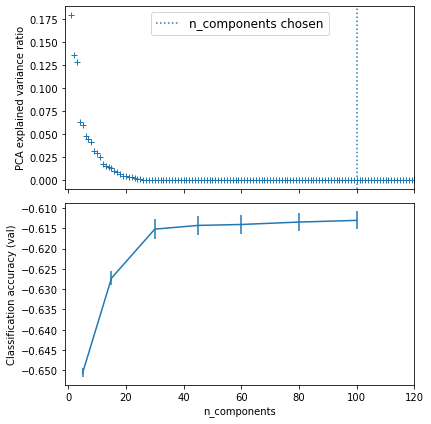

In [54]:
plot_optimized_PCA()

In [56]:
xgb_estimator = XGBClassifier(tree_method="hist",nthread=4,seed=42,eval_metric='error',
                             use_label_encoder=False)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_transformed_train)


xgb_param_grid = {'max_depth': range(2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01 ,0.05]}

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
xgb_search = GridSearchCV(estimator=xgb_estimator,param_grid=xgb_param_grid,scoring = LogLoss,
                          n_jobs = 1, cv = 5, verbose=True) #'roc_auc'

xgb_search.fit(X_transformed_train, y_transformed_train.ravel(),sample_weight=sample_weights)
xgb_search.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='hist', use_label_encoder=False, ...)

In [57]:
lgr_model = log_search.best_estimator_
xgb_model = xgb_search.best_estimator_

In [60]:
def plot_auc_curve(models,X,y):
    fig,axs=plt.subplots(1,2)
    fig.set_size_inches(14,6)
    for i in range(len(models)):
        if models[i] == lgr_model:model_name = 'logistic regression'
        elif models[i] == xgb_model: model_name='XGB classifier'
        y_pred = models[i].predict_proba(X)[:,1]
        fpr, tpr, thresholds = roc_curve(y, y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name=f'{model_name}')
        display.plot(ax=axs[i])
    plt.tight_layout()
    plt.show()

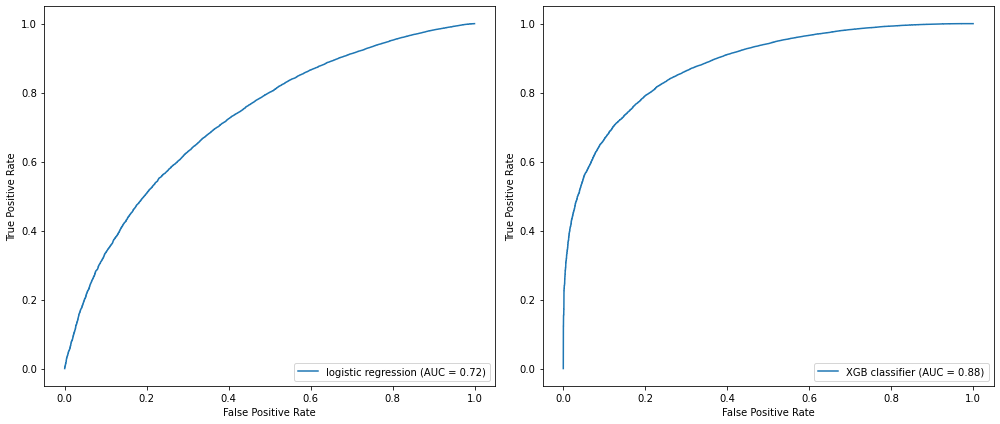

In [61]:
plot_auc_curve([lgr_model,xgb_model],X_transformed_train, y_transformed_train)

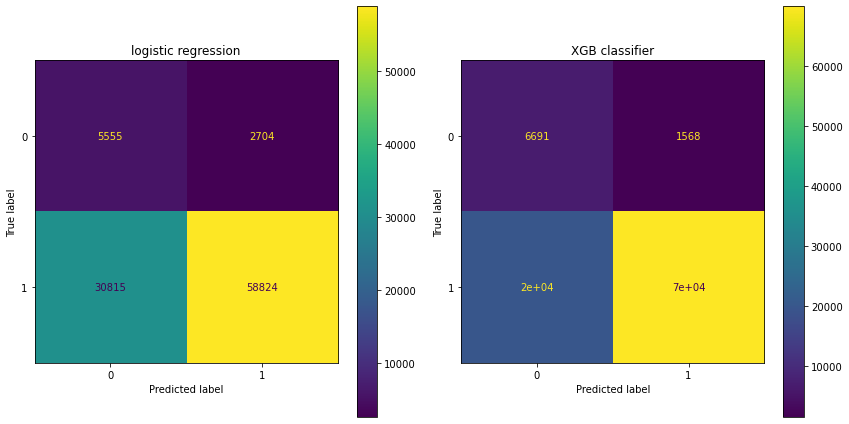

In [64]:
# plot confusion matrix without applying threshold for the lgr_model
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,6)
models = {lgr_model: "logistic regression",
          xgb_model: "XGB classifier"}

for i,model in enumerate(list(models.keys())):
    cf_no_threshold = confusion_matrix(y_transformed_train, model.predict(X_transformed_train))
    disp = ConfusionMatrixDisplay(cf_no_threshold).plot(ax=axs[i])
    disp.ax_.set_title(f'{models[model]}')
plt.tight_layout()
plt.show()

Following the fitted models, one can further tune them: one approach is to maximize the true positive rate (tpr, also called recall) and minimize the false positive rate (fpr). Minimizing fpr effectively implies maximizing true negative rate (TNR = 1 - FPR). Another approach could be to optimize the F-score which is the harmonic mean of precision and recall.
The first approach can be achieved that by finding the probability threshold that maximize the difference between TPR and FPR

In [65]:
def get_threshold_f_score(model, X, y):
    y_scores = model.predict_proba(X)[:,1]
    p, r, thresholds = precision_recall_curve(y, y_scores)
    f_score = (2 * p * r) / (p + r)
    opt_idx = np.argmax(f_score)
    return thresholds[opt_idx], f_score[opt_idx]

def get_threshold_tpr_fpr(model, X, y):
    y_scores = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    opt_idx = np.argmax(tpr-fpr)
    return thresholds[opt_idx], tpr[opt_idx]-fpr[opt_idx]

In [66]:
lgr_threshold, f_score_lgr = get_threshold_f_score(lgr_model, X_transformed_train, y_transformed_train)
xgb_threshold, f_score_xgb = get_threshold_f_score(xgb_model, X_transformed_train, y_transformed_train)

In [67]:
lgr_threshold1, tpr_fpr_lgr = get_threshold_tpr_fpr(lgr_model, X_transformed_train, y_transformed_train)
xgb_threshold1, tpr_fpr_xgb = get_threshold_tpr_fpr(xgb_model, X_transformed_train, y_transformed_train)

In [68]:
print(f'Threshold and f-score of the f1-score optimized logistic regression: {lgr_threshold:.4f}, {f_score_lgr:.4f}')
print(f'Threshold and f-score of the f1-score optimized XGBClassifier: {xgb_threshold:.4f}, {f_score_xgb:.4f}')

Threshold and f-score of the f1-score optimized logistic regression: 0.0764, 0.9560
Threshold and f-score of the f1-score optimized XGBClassifier: 0.2048, 0.9611


In [73]:
print(f'Threshold and (TPR-FPR) of the tpr_fpr optimized logistic regression: {lgr_threshold1:.4f}, {tpr_fpr_lgr:.4f}')
print(f'Threshold and (TPR-FPR) of the tpr_fpr optimized XGBClassifier: {xgb_threshold1:.4f}, {tpr_fpr_xgb:.4f}')

Threshold and (TPR-FPR) of the tpr_fpr optimized logistic regression: 0.4939, 0.3311
Threshold and (TPR-FPR) of the tpr_fpr optimized XGBClassifier: 0.4925, 0.5913


The above f-scores for both models are more than the classification accuracy which is ~91.6% (89639/97898), indicative good learning beyond such benchmark.

In [74]:
def visualize_confusion_matrix(models, X, y_true, lgr_threshold=lgr_threshold,
                               xgb_threshold=xgb_threshold):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)
    categories = ['no', 'yes']
    names =['TN', 'FP', 'FN', 'TP']
    
    for i in range(len(models)):
        if models[i]==lgr_model: threshold, model_name = lgr_threshold, "Logistics Regression"
        elif models[i]==xgb_model: threshold, model_name= xgb_threshold, "XGB Classifier"     
        y_scores = models[i].predict_proba(X)[:,1]
        y_pred = (y_scores >= threshold).astype(int)
        
        cf_matrix = confusion_matrix(y_true,y_pred)
        accu = np.trace(cf_matrix)/np.sum(cf_matrix)
        p = cf_matrix[1,1]/sum(cf_matrix[:,1])
        r = cf_matrix[1,1]/sum(cf_matrix[1,:])
        f1_score = 2*p*r/(p+r)
        metrics_text = f"\n\nAccuracy ={accu:0.3f}\nPrecision={p:0.3f}\nRecall={r:0.3f}\nF1 score={f1_score:0.3f}"
        
        
        counts=[f'{value:0.0f}' for value in cf_matrix.flatten()]
        percents=[f'{value:.3%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = np.asarray([f'{val1}\n{val2}\n{val3}' for \
                     val1,val2,val3 in zip(names,counts,percents)]).reshape(2,2)
        
        sns.heatmap(cf_matrix , annot=labels, fmt='', cmap='Blues', ax=axs[i], \
                   xticklabels=categories, yticklabels=categories \
                   ).set(title=f'Confusion Matrix based on Optimized {model_name}',
                        ylabel='True Turnout', xlabel='Predicted Turnout' + metrics_text)        
    plt.tight_layout()
    plt.show()

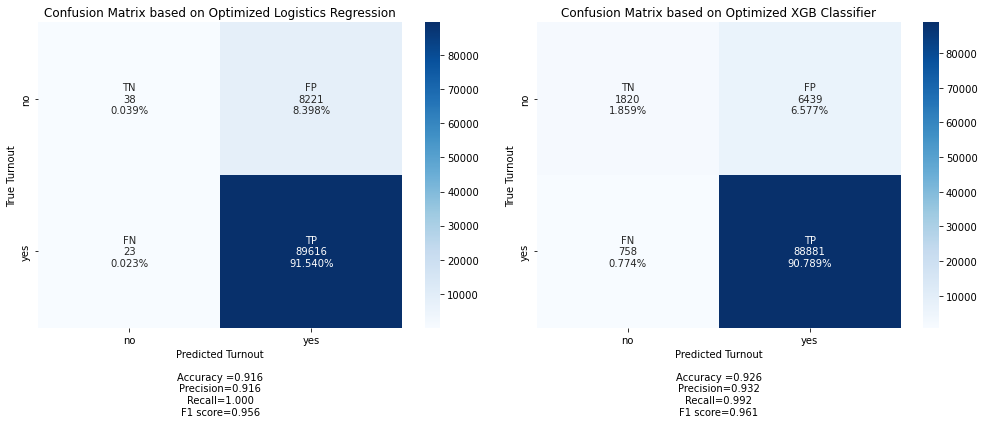

In [75]:
visualize_confusion_matrix([lgr_model,xgb_model],X_transformed_train, y_transformed_train)

Considering how the data is splitted into training and testing set, as well as the precinct_id categories. The test-set might contains precinct_id categories not in train-set. Thus, an attempt is made in the next window to determine which precinct_id categories is present in the test-set but not in the train-set.

A simple approach should have been to split the voter data such that all precinct_ids are present in the training set and then pass a value of 0 for any missing corresponding precinct_id category in the test set. I avoided this, to save time with respect to retraining the models, especially the XGBClassifier.

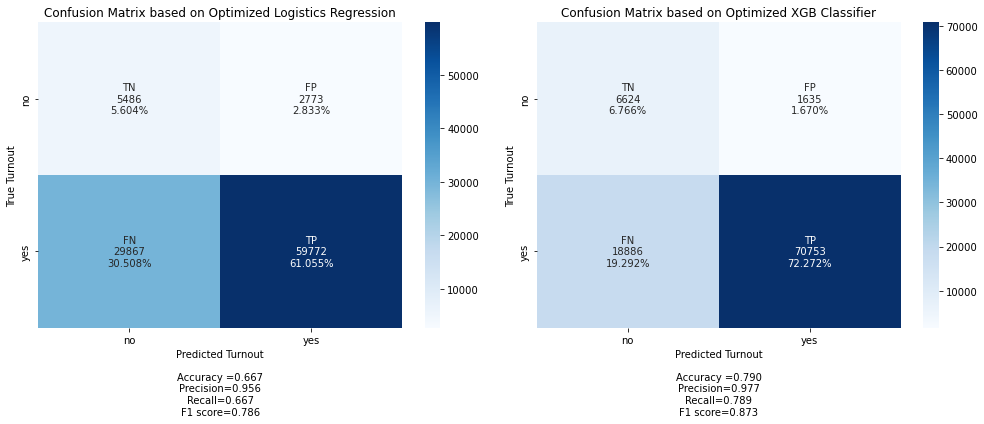

In [76]:
visualize_confusion_matrix([lgr_model,xgb_model],X_transformed_train,
                           y_transformed_train,lgr_threshold=lgr_threshold1,
                               xgb_threshold=xgb_threshold1) #(yes    89639 no      8259

### 6. System testing

In [77]:
# precinct_ids in test-set not in train-set

test_only_precinct_ids = sorted([i for i in test_set.precinct_id.unique() if i not in train_set.precinct_id.unique()])
test_only_precinct_ids

[913.0, 969.0, 978.0, 995.0, 1064.0, 1073.0, 1078.0, 1080.0]

In [84]:
# count and proportion of the test_only_precinct_ids in the test_set

test_only_precinct_ids_len = len(test_set.loc[test_set.precinct_id.isin(test_only_precinct_ids)])
print(f'Count of rows with test_only_precinct_ids: {test_only_precinct_ids_len}')
print(f'Proportion of the test_only_precinct_ids in the test_set: {round(test_only_precinct_ids_len*100/len(test_set),4)} %')

Count of rows with test_only_precinct_ids: 9
Proportion of the test_only_precinct_ids in the test_set: 0.0368 %


In [85]:
new_test_set = test_set.loc[~test_set.precinct_id.isin(test_only_precinct_ids)]
X_test = new_test_set[num_cols + cat_cols + ord_cols]
X_transformed_test = mapper.transform(X_test)

y_test = new_test_set[label_cols]
y_transformed_test = y_test['turnout_code'].apply(lambda x: 1 if x =="yes" else 0)

y_pred_lgr = lgr_model.predict_proba(X_transformed_test)
y_pred_xgb = xgb_model.predict_proba(X_transformed_test)

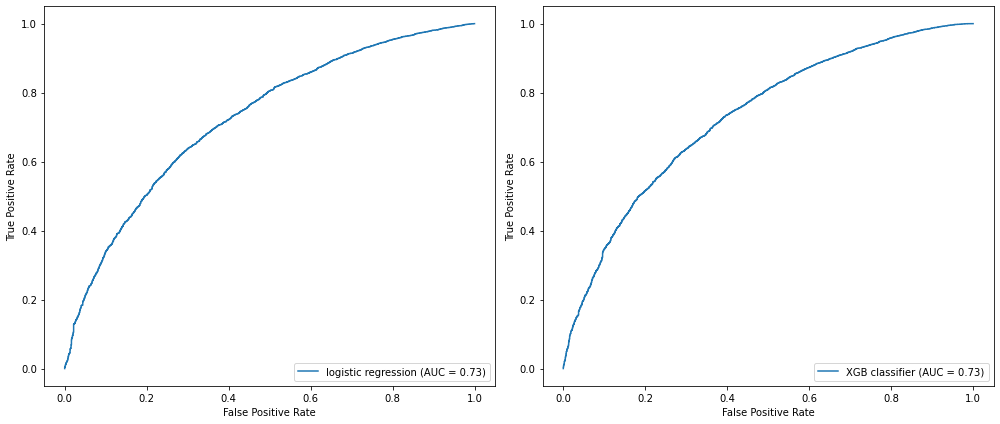

In [86]:
plot_auc_curve([lgr_model,xgb_model],X_transformed_test, y_transformed_test)

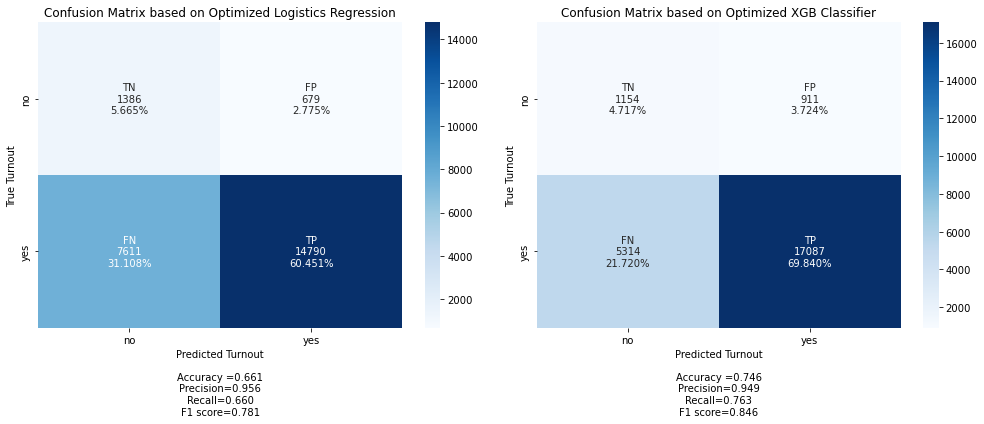

In [89]:
# based on tpr_fpr further optimization of threshold

visualize_confusion_matrix([lgr_model,xgb_model],X_transformed_test,
                           y_transformed_test,lgr_threshold=lgr_threshold1,
                               xgb_threshold=xgb_threshold1)

$ \textbf Summary $: The XGB Classifier generalized better than the Logistic regression model, and log loss was used as the metric cognizant of the fact that we need the prediction probabilities for each data points. The model could benefit more from better feature engineering involved, log-combination, SVD, polynominial relationships. 